#Gather trajectories

In [1]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )

width = 1980.000000, height = 1093.000000


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

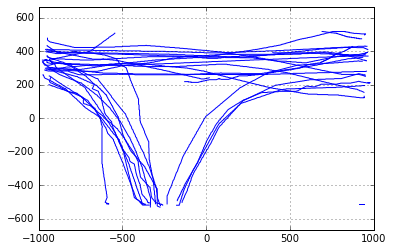

In [3]:
for k in range(len(x_data)):
    plt.plot(x_data[k], y_data[k],'b-')
plt.grid()
plt.axis('equal')
plt.show()

## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L_\theta( x,\dot{x}) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    \frac{q(i-1) - 2 q(i) + q(i+1)}{2} + \nabla V_\theta( q(i) ) = 0.
$$
for $i=1,\dots,N-1$

## Training in a Hermite Polynomial Basis
In this section we consider potential functions of the form
$$
    V(x,y) = \sum_{k_1,k_2=0}^{K} \theta[k_1,k_2] H_{k_1}(x) H_{k_2}(y)
$$
where $H_k$ is the $k$th Hermite polynomial.
The gradients of $V$ is given by
$$
    \partial_x V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_1 H_{k_1-1}(x) H_{k_2}(y) \\
    \partial_y V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_2 H_{k_1}(x) H_{k_2-1}(y) \\
$$

87
64
41


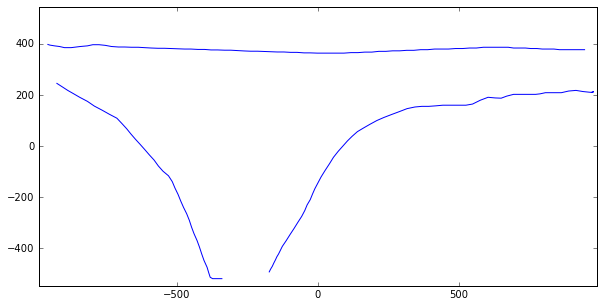

In [6]:
curves = []
curve_indices = [0,6,14,]
for k in curve_indices:
    curves.append( (x_data[k][0::5], y_data[k][0::5]) )
    

#curves.append( np.vstack( [ x_transformed[ 4], y_transformed[ 4] ] ) )
#curves.append( np.vstack( [ x_transformed[ 6], y_transformed[ 6] ] ) )
#curves.append( np.vstack( [ x_transformed[13], y_transformed[13] ] ) )
#curves.append( np.vstack( [ x_transformed[14], y_transformed[14] ] ) )
#curves.append( np.vstack( [ x_transformed[15], y_transformed[15] ] ) )
#curves.append( np.vstack( [ x_transformed[17], y_transformed[17] ] ) )
#curves.append( np.vstack( [ x_transformed[20], y_transformed[20] ] ) )
#curves.append( np.vstack( [ x_transformed[22], y_transformed[22] ] ) )
#curves.append( np.vstack( [ x_transformed[24], y_transformed[24] ] ) )

plt.figure(figsize=(10,5))
for (x,y) in curves:
    plt.plot(x,y,'b-')
    print len(x)
domain = (-width/2,width/2,-height/2,height/2)
plt.axis(domain)
plt.show()

In [7]:
def get_time_scale(x,y):
    dx = x[1:] - x[0:len(x)-1]
    dy = y[1:] - y[0:len(y)-1]
    return (np.sqrt(dx**2 + dy**2)).sum() / float(len(dx))

2759032.28181
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Cost = 2.75903e+06


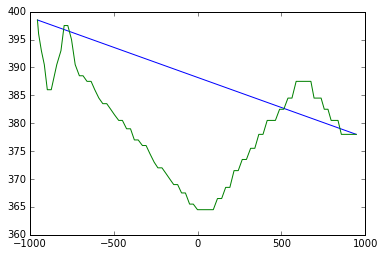

In [9]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for (x,y) in curves:
        n = len(x) #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (k_max+1,k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,(x_obs,y_obs) in zip( x_list, y_list, curves):
        out += np.dot(x-x_obs,x-x_obs) + np.dot(y-y_obs,y-y_obs)
    return out

def EL_constraint(decision_variables , curves, k_max ):
    global width,height
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for (x,y,(x_obs,y_obs)) in zip(x_list,y_list,curves):
        n = x.size
        Delta_t = get_time_scale( x_obs, y_obs )
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) )
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        from numpy.polynomial.legendre import legder, legval2d
        theta_x = legder( theta, m=1, axis=0 )
        theta_y = legder( theta, m=1, axis=1 )
        V_x = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_x ) / width
        V_y = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_y ) / height
        out_list += [a_x+V_x, a_y+V_y]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list)):
        (x_obs,y_obs) = curves[k]
        out[0][k] = x_obs[0] - x[0]
        out[1][k] = x_obs[-1] - x[-1]
        out[2][k] = y_obs[0] - y[0]
        out[3][k] = y_obs[-1] - y[-1]
    return out.flatten()

k_max = 4
constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

theta = np.zeros( (k_max+1, k_max+1) )
guess_list = []
for (x_obs,y_obs) in curves:
    x_guess = np.linspace( x_obs[0], x_obs[-1], len( x_obs))
    y_guess = np.linspace( y_obs[0], y_obs[-1], len( x_obs))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )

def cb_function(x):
    global k_max,curves
    print "Cost = %g" % cost_function(x, curves , k_max )
    return 0

x_out,y_out,theta_out = get_xy_theta( initial_guess , curves, k_max)
plt.plot(x_out[0],y_out[0])
plt.plot(curves[0][0],curves[0][1])
print cost_function(initial_guess, curves, k_max)
#print EL_constraint(initial_guess, curves, k_max)
print boundary_constraint(initial_guess, curves, k_max)
_ = cb_function(initial_guess)

In [24]:
from scipy.optimize import minimize
dir(minimize)
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves, k_max ),
              callback = cb_function, options = {'maxiter':1000})
print res.message
x_list,y_list,theta_opt = get_xy_theta( res.x , curves, k_max)
print theta_opt

Cost = 2.28552e+06
Cost = 48313.4
Cost = 35191.1
Cost = 31277.7
Cost = 30560.8
Cost = 30409.1
Cost = 30250
Cost = 29664.4
Cost = 29177.4
Cost = 28536.2
Cost = 27998.6
Cost = 27437.7
Cost = 26794.5
Cost = 26182.7
Cost = 25806.9
Cost = 25670
Cost = 25606.5
Cost = 25563.3
Cost = 25540.5
Cost = 25531.4
Cost = 25522.6
Cost = 25508.2
Cost = 25490.3
Cost = 25470.1
Cost = 25442.1
Cost = 25389.6
Cost = 25294.9
Cost = 25184.8
Cost = 25128.7
Cost = 25117.7
Cost = 25115.9
Cost = 25115.1
Cost = 25113.5
Cost = 25109.4
Cost = 25099
Cost = 25074.7
Cost = 25024.3
Cost = 24951.9
Cost = 24898.8
Cost = 24886.7
Cost = 24883.7
Cost = 24883.3
Cost = 24883.1
Cost = 24882.4
Cost = 24880.9
Cost = 24876.8
Cost = 24867.5
Cost = 24845.5
Cost = 24804.3
Cost = 24750.8
Cost = 24717.3
Cost = 24711
Cost = 24710.7
Cost = 24710.7
Cost = 24710.7
Cost = 24710.7
Cost = 24710.7
Cost = 24710.7
Cost = 24710.7
Cost = 24710.6
Cost = 24710.4
Cost = 24709.8
Cost = 24708.3
Cost = 24705
Cost = 24694.8
Cost = 24675.7
Cost = 24594.2
C

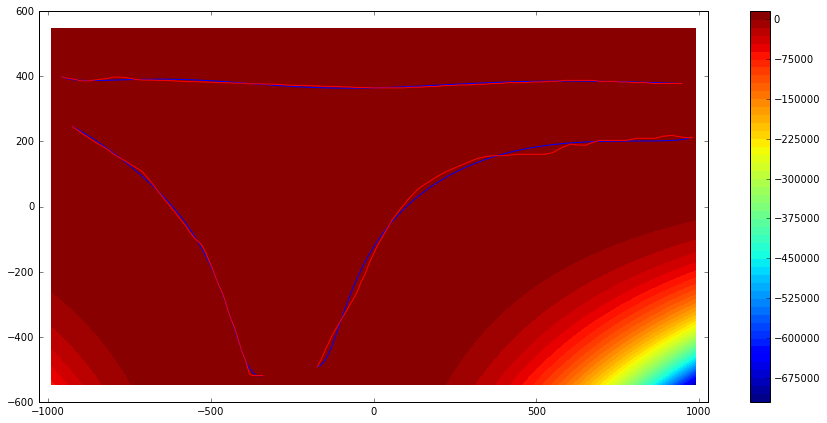

In [25]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
n_curves = len(curves)
from numpy.polynomial.legendre import legval2d
V = legval2d(2*x_grid/width , 2*y_grid/height, theta_opt)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 50)
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0] , curves[k][1],'r-')
axis_size= plt.axis('equal')

In [57]:
np.save('theta_opt',theta_opt)

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

In [38]:
def Stormer_Verlet(x0,x1,y0,y1,n_steps, Delta_t=1.0):
    global width, height
    from numpy.polynomial.legendre import legder, legval2d
    theta_opt_x = legder( theta_opt, axis=0, m=1)
    theta_opt_y = legder( theta_opt, axis=1, m=1)
    x_pred = np.zeros(n_steps)
    y_pred = np.zeros(n_steps)
    x_pred[0],x_pred[1] = (x0,x1)
    y_pred[0],y_pred[1] = (y0,y1)
    for k in range(n_steps-2):
        x0,x1 = x_pred[k], x_pred[k+1]
        y0,y1 = y_pred[k], y_pred[k+1]
        V_x = 2*legval2d( 2*x1/width , 2*y1/height, theta_opt_x ) / width
        V_y = 2*legval2d( 2*x1/width , 2*y1/height, theta_opt_y ) / height
        x_pred[k+2] = 2*x1 - x0 - Delta_t**2 * V_x
        y_pred[k+2] = 2*y1 - y0 - Delta_t**2 * V_y
    return x_pred, y_pred

In [41]:
curve_ind = 2
start = 0
x0,x1 = x_list[curve_ind][start], x_list[curve_ind][start+1]
y0,y1 = y_list[curve_ind][start], y_list[curve_ind][start+1]
t_max = len(x_list[curve_ind])
Delta_t = get_time_scale(x_list[curve_ind],y_list[curve_ind])
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max)
print x_pred

[-340.         -350.85068955 -360.82934878 -370.07421219 -378.75252976
 -387.03952119 -395.102066   -403.08835965 -411.12314882 -419.30730433
 -427.72025595 -436.42395149 -445.46730267 -454.89040995 -464.7281496
 -475.01293225 -485.77659955 -497.05152296 -508.87101801 -521.26920342
 -534.28042888 -547.93837916 -562.27494193 -577.318908   -593.09455713
 -609.62017202 -626.90651628 -644.95530903 -663.75772742 -683.29296771
 -703.5268958  -724.41081886 -745.88041429 -767.85486251 -790.23625025
 -812.90934162 -835.74185012 -858.58537455 -881.27716337 -903.64282563
 -925.50000022]


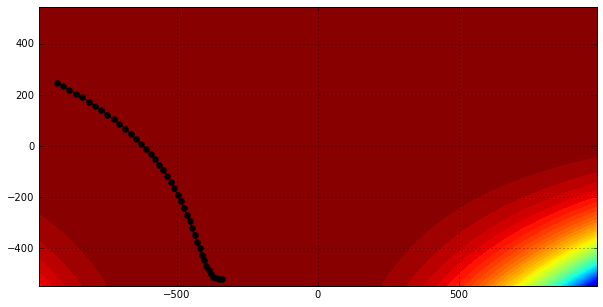

In [42]:
plt.figure(figsize = (10,5))
plt.contourf(x_grid,y_grid,V , 50)
plt.plot(x_list[curve_ind],y_list[curve_ind],'k-')
plt.plot(x_pred,y_pred,'ko')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)
plt.show()

## Predictions on Test data
Let's do the same thing on some of the test data

speed = 4.839795
5546341.02149


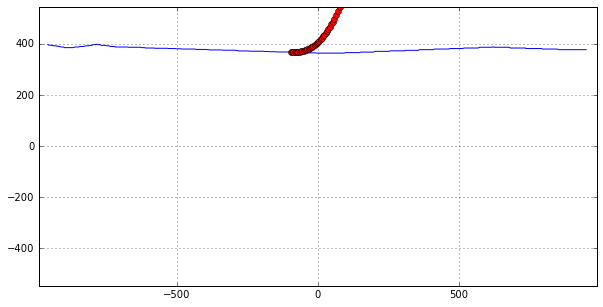

In [70]:
curve_ind = 0
start = 200
x0 = x_data[curve_ind][start]
x1 = x0 + ( x_data[curve_ind][start+3] - x_data[curve_ind][start-3] ) / float(6)
y0 = y_data[curve_ind][start]
y1 = y0 + ( y_data[curve_ind][start+3] - y_data[curve_ind][start-3] ) / float(6)
speed = np.sqrt( (y1-y0)**2 + (x1-x0)**2)
print "speed = %f" % speed
t_max = 50 #len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max)
print y_pred.max()
fig = plt.figure(figsize=(10,5))
plt.plot(x_data[curve_ind], y_data[curve_ind],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)